In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

sys.path.append('../..')
from sla.detectors import AutoencoderDetector

In [2]:
df = pd.read_csv('./data/sensor.csv', index_col=0)

In [3]:
df_data = df[['timestamp', 'sensor_02', 'machine_status']]

In [4]:
from sklearn.preprocessing import StandardScaler
normal_data = df_data[df_data['machine_status'] == 'NORMAL']
scaler = StandardScaler()
scaler.fit(normal_data[['sensor_02']])
df_scaled = df_data.copy()
df_scaled['sensor_02'] = scaler.transform(df_scaled[['sensor_02']])
df_scaled.head()

,timestamp,sensor_02,machine_status
0,2018-04-01 00:00:00,0.838447,NORMAL
1,2018-04-01 00:01:00,0.838447,NORMAL
2,2018-04-01 00:02:00,0.838447,NORMAL
3,2018-04-01 00:03:00,0.815341,NORMAL
4,2018-04-01 00:04:00,0.838447,NORMAL


In [5]:
def create_sequences_with_targets(data, window_size=60, lag=45):
    """
    Creates sequences of data using a rolling window approach.
    For each sequence, counts the number of anomalous points.
    
    Parameters:
    - data: DataFrame with timestamp, sensor value, and machine_status
    - window_size: Size of each sequence (number of data points)
    - lag: Number of steps to shift between sequences
    
    Returns:
    - DataFrame with sequences and target values
    """
    sequences = []
    
    for i in range(0, len(data) - window_size + 1, lag):
        window = data.iloc[i:i+window_size]
        anomaly_count = sum(window['machine_status'] != 'NORMAL')
        sequence = window['sensor_02'].values        
        sequences.append({
            **{f't{j}': sequence[j] for j in range(window_size)},
            'target': float(anomaly_count)
        })
    
    return pd.DataFrame(sequences)

sequence_data = create_sequences_with_targets(df_scaled, window_size=60, lag=45)

print(f"Created {len(sequence_data)} sequences")
sequence_data.head()

Created 4895 sequences


,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t51,t52,t53,t54,t55,t56,t57,t58,t59,target
0,0.838447,0.838447,0.838447,0.815341,0.838447,0.815341,0.815341,0.815341,0.815341,0.815341,...,0.792233,0.792233,0.792235,0.746018,0.792235,0.792235,0.815341,0.792235,0.815341,0.0
1,0.746018,0.792235,0.746018,0.792235,0.792233,0.792233,0.792233,0.792233,0.792235,0.746018,...,0.815341,0.792235,0.815341,0.792235,0.792233,0.792233,0.792235,0.746018,0.792235,0.0
2,0.792235,0.746018,0.815341,0.792235,0.815341,0.815341,0.815341,0.792235,0.815341,0.792235,...,0.722912,0.746018,0.722912,0.746018,0.699805,0.722911,0.746018,0.722912,0.746018,0.0
3,0.722912,0.746018,0.722912,0.722911,0.722911,0.722911,0.722912,0.746018,0.722912,0.746018,...,0.699805,0.699805,0.699805,0.699805,0.699805,0.722912,0.699805,0.699805,0.722912,0.0
4,0.699805,0.699805,0.699805,0.722912,0.722912,1.023306,0.699805,0.699805,0.699805,0.699805,...,0.676699,0.676699,0.699805,0.676699,0.676699,0.699805,0.676699,0.699805,0.676699,0.0


In [6]:
filtered_sequence_data = sequence_data[(sequence_data['target'] == 0) | (sequence_data['target'] == 60)]
filtered_sequence_data = filtered_sequence_data.reset_index(drop=True)

print(f"Original dataset: {len(sequence_data)} sequences")
print(f"Filtered dataset: {len(filtered_sequence_data)} sequences")
print(f"Kept {len(filtered_sequence_data)/len(sequence_data)*100:.2f}% of the original data")

value_counts = filtered_sequence_data['target'].value_counts()
print("\nTarget value distribution:")
print(value_counts)

filtered_sequence_data.head()

Original dataset: 4895 sequences
Filtered dataset: 4877 sequences
Kept 99.63% of the original data

Target value distribution:
target
0.0     4564
60.0     313
Name: count, dtype: int64


,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t51,t52,t53,t54,t55,t56,t57,t58,t59,target
0,0.838447,0.838447,0.838447,0.815341,0.838447,0.815341,0.815341,0.815341,0.815341,0.815341,...,0.792233,0.792233,0.792235,0.746018,0.792235,0.792235,0.815341,0.792235,0.815341,0.0
1,0.746018,0.792235,0.746018,0.792235,0.792233,0.792233,0.792233,0.792233,0.792235,0.746018,...,0.815341,0.792235,0.815341,0.792235,0.792233,0.792233,0.792235,0.746018,0.792235,0.0
2,0.792235,0.746018,0.815341,0.792235,0.815341,0.815341,0.815341,0.792235,0.815341,0.792235,...,0.722912,0.746018,0.722912,0.746018,0.699805,0.722911,0.746018,0.722912,0.746018,0.0
3,0.722912,0.746018,0.722912,0.722911,0.722911,0.722911,0.722912,0.746018,0.722912,0.746018,...,0.699805,0.699805,0.699805,0.699805,0.699805,0.722912,0.699805,0.699805,0.722912,0.0
4,0.699805,0.699805,0.699805,0.722912,0.722912,1.023306,0.699805,0.699805,0.699805,0.699805,...,0.676699,0.676699,0.699805,0.676699,0.676699,0.699805,0.676699,0.699805,0.676699,0.0


In [7]:
columns_with_nans = filtered_sequence_data.columns[filtered_sequence_data.isna().any()].tolist()
print(f"Columns containing NaN values: {columns_with_nans}")

for column in columns_with_nans:
    median_value = filtered_sequence_data[column].median()
    filtered_sequence_data[column].fillna(median_value, inplace=True)

remaining_nans = filtered_sequence_data.isna().sum().sum()
print(f"\nRemaining NaN values after filling: {remaining_nans}")

filtered_sequence_data.head()

Columns containing NaN values: ['t2', 't3', 't4', 't5', 't8', 't12', 't13', 't14', 't27', 't33', 't34', 't35', 't36', 't37', 't38', 't39', 't40', 't47', 't48', 't49', 't50', 't53', 't57', 't58', 't59']

Remaining NaN values after filling: 0


/tmp/ipykernel_86145/2340087983.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_sequence_data[column].fillna(median_value, inplace=True)
/tmp/ipykernel_86145/2340087983.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t51,t52,t53,t54,t55,t56,t57,t58,t59,target
0,0.838447,0.838447,0.838447,0.815341,0.838447,0.815341,0.815341,0.815341,0.815341,0.815341,...,0.792233,0.792233,0.792235,0.746018,0.792235,0.792235,0.815341,0.792235,0.815341,0.0
1,0.746018,0.792235,0.746018,0.792235,0.792233,0.792233,0.792233,0.792233,0.792235,0.746018,...,0.815341,0.792235,0.815341,0.792235,0.792233,0.792233,0.792235,0.746018,0.792235,0.0
2,0.792235,0.746018,0.815341,0.792235,0.815341,0.815341,0.815341,0.792235,0.815341,0.792235,...,0.722912,0.746018,0.722912,0.746018,0.699805,0.722911,0.746018,0.722912,0.746018,0.0
3,0.722912,0.746018,0.722912,0.722911,0.722911,0.722911,0.722912,0.746018,0.722912,0.746018,...,0.699805,0.699805,0.699805,0.699805,0.699805,0.722912,0.699805,0.699805,0.722912,0.0
4,0.699805,0.699805,0.699805,0.722912,0.722912,1.023306,0.699805,0.699805,0.699805,0.699805,...,0.676699,0.676699,0.699805,0.676699,0.676699,0.699805,0.676699,0.699805,0.676699,0.0


In [ ]:
normal_data = filtered_sequence_data[filtered_sequence_data['target'] == 0].reset_index(drop=True)
anomalous_data = filtered_sequence_data[filtered_sequence_data['target'] == 60].reset_index(drop=True)

print(f"Normal data: {len(normal_data)} sequences")
print(f"Anomalous data: {len(anomalous_data)} sequences")

train_val_data, test_data = train_test_split(normal_data, test_size=0.10, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.05/0.90, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("\nNormal data splits:")
print(f"Train set: {len(train_data)} sequences ({len(train_data)/len(normal_data)*100:.2f}%)")
print(f"Validation set: {len(val_data)} sequences ({len(val_data)/len(normal_data)*100:.2f}%)")
print(f"Test set: {len(test_data)} sequences ({len(test_data)/len(normal_data)*100:.2f}%)")
print(f"Total: {len(train_data) + len(val_data) + len(test_data)} sequences")

print("\nAnomalous data:")
print(f"Total: {len(anomalous_data)} sequences")

Normal data: 4564 sequences
Anomalous data: 313 sequences

Normal data splits:
Train set: 3878 sequences (84.97%)
Validation set: 229 sequences (5.02%)
Test set: 457 sequences (10.01%)
Total: 4564 sequences

Anomalous data:
Total: 313 sequences


In [ ]:
ae = AutoencoderDetector(n_features=1, seq_len=60)

In [10]:
history, weights = ae.fit(train_data.iloc[:, :-1].to_numpy())

Epoch 0, Train Loss: 3.4612
Epoch 1, Train Loss: 1.0723
Epoch 2, Train Loss: 0.8899
Epoch 3, Train Loss: 0.8727
Epoch 4, Train Loss: 0.8182
Epoch 5, Train Loss: 0.7963
Epoch 6, Train Loss: 0.7698
Epoch 7, Train Loss: 0.7469
Epoch 8, Train Loss: 0.7327
Epoch 9, Train Loss: 0.7209
Epoch 10, Train Loss: 0.7066
Epoch 11, Train Loss: 0.6906
Epoch 12, Train Loss: 0.6667
Epoch 13, Train Loss: 0.6764
Epoch 14, Train Loss: 0.6466
Epoch 15, Train Loss: 0.6355
Epoch 16, Train Loss: 0.6264
Epoch 17, Train Loss: 0.6060
Epoch 18, Train Loss: 0.5840
Epoch 19, Train Loss: 0.5471


In [11]:
ae.model.load_state_dict(weights)

<All keys matched successfully>

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae.model.eval()
ae.model.to(device)
train_sequences = []
for i in range(len(train_data)):
    seq = train_data.iloc[i, :-1].to_numpy().reshape(60, 1)
    train_sequences.append(seq)

anomalies_train = []
for seq in train_sequences:
    pred = ae.predict(seq)
    anomalies_train.append(pred)

val_sequences = []
for i in range(len(val_data)):
    seq = val_data.iloc[i, :-1].to_numpy().reshape(60, 1)
    val_sequences.append(seq)

anomalies_val = []
for seq in val_sequences:
    pred = ae.predict(seq)
    anomalies_val.append(pred)

test_sequences = []
for i in range(len(test_data)):
    seq = test_data.iloc[i, :-1].to_numpy().reshape(60, 1)
    test_sequences.append(seq)

anomalies_test = []
for seq in test_sequences:
    pred = ae.predict(seq)
    anomalies_test.append(pred)

In [13]:
train_pred_labels = np.array([1 if np.any(pred == 1) else 0 for pred in anomalies_train])
val_pred_labels = np.array([1 if np.any(pred == 1) else 0 for pred in anomalies_val])
test_pred_labels = np.array([1 if np.any(pred == 1) else 0 for pred in anomalies_test])

train_true_labels = np.zeros(len(train_data))
val_true_labels = np.zeros(len(val_data))
test_true_labels = np.zeros(len(test_data))

def calculate_metrics(true_labels, pred_labels):
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels, labels=[0, 1]).ravel()
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0 
    
    return {
        'true_negatives': tn,
        'false_positives': fp,
        'true_negative_rate': specificity,
        'false_positive_rate': fpr
    }

train_metrics = calculate_metrics(train_true_labels, train_pred_labels)
val_metrics = calculate_metrics(val_true_labels, val_pred_labels)
test_metrics = calculate_metrics(test_true_labels, test_pred_labels)

print("Training Set Metrics:")
print(f"True Negatives: {train_metrics['true_negatives']} ({train_metrics['true_negative_rate']:.4f})")
print(f"False Positives: {train_metrics['false_positives']} ({train_metrics['false_positive_rate']:.4f})")
print()

print("Validation Set Metrics:")
print(f"True Negatives: {val_metrics['true_negatives']} ({val_metrics['true_negative_rate']:.4f})")
print(f"False Positives: {val_metrics['false_positives']} ({val_metrics['false_positive_rate']:.4f})")
print()

print("Test Set Metrics:")
print(f"True Negatives: {test_metrics['true_negatives']} ({test_metrics['true_negative_rate']:.4f})")
print(f"False Positives: {test_metrics['false_positives']} ({test_metrics['false_positive_rate']:.4f})")

Training Set Metrics:
True Negatives: 2457 (0.6336)
False Positives: 1421 (0.3664)

Validation Set Metrics:
True Negatives: 138 (0.6026)
False Positives: 91 (0.3974)

Test Set Metrics:
True Negatives: 289 (0.6324)
False Positives: 168 (0.3676)


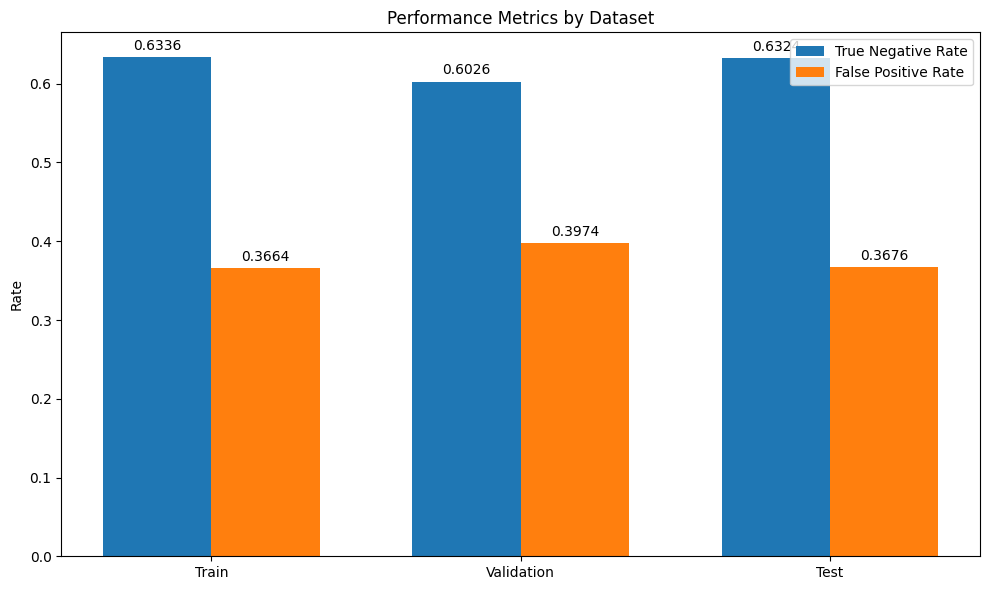

In [14]:
datasets = ['Train', 'Validation', 'Test']
tn_rates = [train_metrics['true_negative_rate'], val_metrics['true_negative_rate'], test_metrics['true_negative_rate']]
fp_rates = [train_metrics['false_positive_rate'], val_metrics['false_positive_rate'], test_metrics['false_positive_rate']]

x = np.arange(len(datasets))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, tn_rates, width, label='True Negative Rate')
rects2 = ax.bar(x + width/2, fp_rates, width, label='False Positive Rate')

ax.set_ylabel('Rate')
ax.set_title('Performance Metrics by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [15]:
anomalous_sequences = []
for i in range(len(anomalous_data)):
    seq = anomalous_data.iloc[i, :-1].to_numpy().reshape(60, 1)
    anomalous_sequences.append(seq)

anomalies_anomalous = []
for seq in anomalous_sequences:
    pred = ae.predict(seq)
    anomalies_anomalous.append(pred)

anomalous_pred_labels = np.array([1 if np.any(pred == 1) else 0 for pred in anomalies_anomalous])
anomalous_true_labels = np.ones(len(anomalous_data))

anomalous_metrics = confusion_matrix(anomalous_true_labels, anomalous_pred_labels, labels=[0, 1]).ravel()
if len(anomalous_metrics) == 4:
    tn_anom, fp_anom, fn_anom, tp_anom = anomalous_metrics
else:
    if np.sum(anomalous_pred_labels) == 0:
        tn_anom, fp_anom, fn_anom, tp_anom = 0, 0, len(anomalous_true_labels), 0
    else:  
        tn_anom, fp_anom, fn_anom, tp_anom = 0, 0, 0, len(anomalous_true_labels)

tpr = tp_anom / (tp_anom + fn_anom) if (tp_anom + fn_anom) > 0 else 0
fnr = fn_anom / (tp_anom + fn_anom) if (tp_anom + fn_anom) > 0 else 0

print("Anomalous Data Metrics:")
print(f"True Positives: {tp_anom} ({tpr:.4f})")
print(f"False Negatives: {fn_anom} ({fnr:.4f})")

Anomalous Data Metrics:
True Positives: 304 (0.9712)
False Negatives: 9 (0.0288)


In [16]:
ae.feature_importance(train_data.iloc[:, :-1].to_numpy())

,feature,importance
0,feature_0,1.0
